In [18]:
#from pyscf import gto, scf, fci, lo
#import netket as nk; import netket.experimental as nkx
import numpy as np
import time
#import itertools
#import qiskit
#from qiskit.quantum_info import Pauli, SparsePauliOp
from collections import defaultdict
#import tensorflow as tf
#import sys
import os
import pandas as pd
#import itertools
from itertools import product
import matplotlib.pyplot as plt
#sys.path.append(os.path.dirname(os.getcwd()) + "/SAMPLER_LOCAL_IMPORT")
#from Sampling_Quantum import *
#from New_MCMC_Proposal import *
#sys.path.append(os.getcwd() + "/Code_download_Bell_2")
from MCMC_funs_Leyden import *

#print(qiskit.version.get_version_info())
os.getcwd()

"c:\\Users\\vinit\\Downloads\\Research\\Quantum-Sampling\\Manas' Proposals"

In [19]:
def all_configs(n):
    return [np.array(v) for v in product([-1, 1], repeat=n)]



def Sampling_MCMC_trajectories(problem_inst, Transition_matrix, sample_size=10000, 
                               burn=1000, method='Quantum', init_config=None):

    n = problem_inst.n
    beta = problem_inst.T
    prob_dist = np.zeros(2**n)

    #exact_dist = np.exp(-beta * Proposal_object.Energy_array)
    #exact_dist = exact_dist / np.sum(exact_dist)

    #err_hist = []
    key_list = []

    if init_config==None:
        s = np.random.choice([1,-1],size=n)
    else: s = init_config

    int_key = spinconf2int(s)
    #print(int_key)
    
    for k in range(burn):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
         int_key = generate_move(transition_mat=Transition_matrix, state=int_key)

    for k in range(sample_size):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
        int_key = generate_move(transition_mat=Transition_matrix, state=int_key)
        #key = spinconf2int(s)
        prob_dist[int_key] +=1
        key_list.append(int_key)

    
    return np.flip(prob_dist/np.sum(prob_dist)), key_list

In [20]:
def normalize_transition_matrix(T, eps=1e-12, verbose=False):
    T = T.copy()
    T[T < 0] = 0.0
    col_sums = T.sum(axis=0)
    bad = np.abs(col_sums) <= eps
    good = ~bad
    if np.any(good):
        T[:, good] /= col_sums[None, good]
    if np.any(bad):
        T[:, bad] = 1.0 / T.shape[0]
        if verbose:
            print(f"{bad.sum()} columns had near-zero sum. Reset to uniform.")
    return T


def Cov_computer(sample_vector_stacks):
    #sample_vector_stacks is a row-wise stack of last k sample vectors. Each sample vector of length n
    X = np.asarray(sample_vector_stacks, dtype=float)
    #print(X)
    if X.shape[0] <= 1:
        return np.eye(X.shape[1])
    mean = X.mean(axis=0)
    #print(np.tile(mean, (X.shape[0],1)))
    diffs = X - np.tile(mean, (X.shape[0],1))
    return (diffs.T @ diffs) / (X.shape[0] - 1)


## Non-Vectorized Code

In [21]:
def grad_U_mala(x, J, h, alpha):
    v = np.tanh(alpha * x)
    sech_sq = 1.0 * (1 - v ** 2)
    return alpha * sech_sq * (h + 2 * J @ v)


def normal_dist_logpdf(y, mean, P, epsilon):
    diff = y - mean
    z = np.linalg.solve(P, diff)          # P z = diff  z = P^-1 diff
    quad_form = float(z @ z)
    logdet = 2.0*np.sum(np.log(np.diag(P))) + 2.0*y.size*np.log(epsilon)
    return -0.5 * (y.size * np.log(2.0 * np.pi) + logdet + (epsilon**(-2))*quad_form)


def adaptive_MALA_step_new(x, P, cov, epsilon, problem_inst, alpha=3.0):
    J_Q = problem_inst.J_quantum
    h_Q = problem_inst.h_quantum

    mean_shift_at_xnew = x + (0.5*epsilon**2) * problem_inst.T * cov @ grad_U_mala(x, J_Q, h_Q, alpha)

    #white_noise_term = np.random.multivariate_normal(np.zeros(len(x)), epsilon**2 * np.dot(P, np.conjugate(P).T))
    x_new = np.random.multivariate_normal(mean=mean_shift_at_xnew, cov=epsilon**2 * np.dot(P, np.conjugate(P).T), size=1)[0]
    #print(x_new)

    mean_shift_at_xold = x_new + (0.5*epsilon**2) * problem_inst.T * cov @ grad_U_mala(x_new, J_Q, h_Q, alpha)

    v_old = np.sign(np.tanh(alpha * x))
    v_new = np.sign(np.tanh(alpha * x_new))
    E_old = problem_inst.E_arr[::-1][spinconf2int(v_old)]
    E_new = problem_inst.E_arr[::-1][spinconf2int(v_new)]

    log_prop_dist_fwd = normal_dist_logpdf(x_new, mean_shift_at_xnew, P, epsilon)
    log_prop_dist_rev = normal_dist_logpdf(x, mean_shift_at_xold, P, epsilon)

    log_accept_ratio = -problem_inst.T * (E_new - E_old) + (log_prop_dist_rev - log_prop_dist_fwd)
    accept_prob = min(1.0, np.exp(log_accept_ratio))

    if np.random.rand() < accept_prob:
        return x_new, v_new
    else:
        return x, v_old


def adaptive_MALA_T_matrix(problem_inst, alpha=3.0, epsilon=0.3, num_samples=500):
    from tqdm import tqdm

    n = problem_inst.n
    #beta = problem_inst.T

    configs = all_configs(n)
    idx_map = {tuple(c): i for i, c in enumerate(configs)}
    T = np.zeros((1 << n, 1 << n))

    burn_in = 1000

    for v in tqdm(configs, desc="Building T matrix"):
        x = np.arctanh(np.clip(v, -0.999, 0.999)) / alpha
        cov = np.eye(n)
        P = np.eye(n)

        counts = defaultdict(int)

        v_samples = []
        x_samples = []
        adapt_window = 20

        tmg = time.time()

        for step in range(1, num_samples+1):
            x, v_new = adaptive_MALA_step_new(x, P, cov, epsilon, problem_inst, alpha=3.0)

            v_samples.append(v_new)
            x_samples.append(x)

            key = tuple(v_new.astype(int))
            counts[key] = counts.get(key, 0) + 1

            if (step) % adapt_window == 0 and step > 200 and step <= burn_in:
                if len(x_samples) >= 80:
                    #x_hist = np.array([np.arctanh(np.clip(np.tanh(alpha * x0), -0.999, 0.999)) / alpha for x0 in v_samples[-50:]])
                    x_hist = [x for x in x_samples[-80:]]

                else:
                    #x_hist = np.array([np.arctanh(np.clip(np.tanh(alpha * x0), -0.999, 0.999)) / alpha for x0 in v_samples])
                    x_hist = [x for x in x_samples[:]]


                cov_new = Cov_computer(x_hist)
                gamma = 0.1             # diminishing
                cov = (1.0 - gamma) * cov_new + gamma * cov
                cov = 0.5 * (cov + cov.T)
                cov = cov + 1e-5 * np.eye(len(x))
                P = np.linalg.cholesky(cov) 

        i = idx_map[tuple(v)]
        total = sum(counts.values())

        for v_prime, c in counts.items():
            j = idx_map[v_prime]

            if j != i :
                T[j, i] = c / total

        T[i,i] = 1-sum(T[:,i])

    T = normalize_transition_matrix(T, eps=1e-12, verbose=True)

    return T



## Vectorized Code

In [ ]:
def grad_U_mala_batch(X, J, H, alpha):
    V = np.tanh(alpha * X)                      # (B, n)
    sech_sq = 1.0 - V**2                        # (B, n)
    return alpha * sech_sq * (H[None, :] + 2.0 * V @ J.T)

def normal_dist_logpdf_batch(Y, Mean, P, epsilon):
    B, n = Y.shape
    diff = (Y - Mean)                            # (B, n)

    Z = np.linalg.solve(P, diff.T)               # (n, B)
    quad = np.sum(Z * Z, axis=0)                 # (B,)

    logdet = 2.0 * np.sum(np.log(np.diag(P))) + 2.0 * n * np.log(epsilon)  # scalar
    return -0.5 * (n * np.log(2.0 * np.pi) + logdet + (epsilon**(-2)) * quad)

def spins_to_index(V):
    """
    V: (B, n) spins in {-1, +1}
    Returns (B,) indices 
    """
    V = np.asarray(V)
    bits = (V < 0).astype(np.int64)                 # +1 -> 0, -1 -> 1
    n = V.shape[1]
    weights = (1 << np.arange(n-1, -1, -1, dtype=np.int64))  # MSB at column 0
    return bits @ weights


# ---------- Batched MALA step ----------

def adaptive_MALA_step_new_batch(X, P, cov, epsilon, problem_inst, alpha=3.0):
    B, n = X.shape
    Tinv = problem_inst.T 
    J_Q = problem_inst.J_quantum
    h_Q = problem_inst.h_quantum

    grad_X = grad_U_mala_batch(X, J_Q, h_Q, alpha)                 # (B, n)
    mean_fwd = X + 0.5 * (epsilon**2) * Tinv * (grad_X @ cov.T)  # (B, n)

    # ----- Sample proposal with shared covariance epsilon^2 * P P^T -----
    # Draw Z ~ N(0, I), then X_new = mean_fwd + epsilon * Z @ P^T
    Z = np.random.randn(B, n)
    X_new = mean_fwd + epsilon * (Z @ P.T)                          # (B, n)

    grad_Xnew = grad_U_mala_batch(X_new, J_Q, h_Q, alpha)           # (B, n)
    mean_rev = X_new + 0.5 * (epsilon**2) * Tinv * (grad_Xnew @ cov.T)

    V_old = np.sign(np.tanh(alpha * X))                             # (B, n), in {-1, +1}
    V_new = np.sign(np.tanh(alpha * X_new))

    idx_old = spins_to_index(V_old)
    idx_new = spins_to_index(V_new)
    E_table = problem_inst.E_arr[::-1]                    
    E_old = E_table[idx_old]                                        
    E_new = E_table[idx_new]                                        

    log_q_fwd = normal_dist_logpdf_batch(X_new, mean_fwd, P, epsilon)    
    log_q_rev = normal_dist_logpdf_batch(X,     mean_rev, P, epsilon)    

    log_acc = -Tinv * (E_new - E_old) + (log_q_rev - log_q_fwd)     
    acc_prob = np.clip(np.exp(np.minimum(0.0, log_acc)), 0.0, 1.0)  
    accept_mask = (np.random.rand(B) < acc_prob)

    # Apply accepts with boolean mask
    X_next = np.where(accept_mask[:, None], X_new, X)
    V_next = np.where(accept_mask[:, None], V_new, V_old)

    return X_next, V_next



def adaptive_MALA_T_matrix_vec(problem_inst, alpha=3.0, epsilon=0.3, num_samples=500):
    from tqdm import tqdm

    n = problem_inst.n

    V = all_configs(n)
    origin_idx = spins_to_index(V)   
    #print(origin_idx)

    T = np.zeros((1 << n, 1 << n))

    burn_in = 1000

    X = np.arctanh(np.clip(V, -0.999, 0.999)) / alpha
    cov = np.eye(n)
    P = np.eye(n)

    counts = defaultdict(int)
    counts_mat = np.zeros((1<<n, 1<<n), dtype=np.int64)

    adapt_window = 20
    cov_samples = 20                                  # keep last K samples for covariance computation

    # --- rolling buffer of shape (K, B, n) ---
    buffer = np.empty((cov_samples, 2**n, n), dtype=float)
    buf_idx = 0          # next write position

    tmg = time.time()

    for step in tqdm(range(1, num_samples+1)):
        X, V = adaptive_MALA_step_new_batch(X, P, cov, epsilon, problem_inst, alpha=3.0)
        dest_idx = spins_to_index(V)    
        #x, v_new = adaptive_MALA_step_new(x, P, cov, epsilon, problem_inst, alpha=3.0)

        if step > num_samples // 10:  ## Burn-in for counts_mat
            np.add.at(counts_mat, (dest_idx, origin_idx), 1)

        buffer[buf_idx] = X
        buf_idx = (buf_idx + 1) % cov_samples

        # update counts (vectorized)
        uniq, cnts = np.unique(V.astype(int), axis=0, return_counts=True)
        for row, c in zip(uniq, cnts):
            counts[tuple(row.tolist())] = counts.get(tuple(row.tolist()), 0) + int(c)

        # adapt covariance on schedule
        if (step % adapt_window == 0) and (step > 100) and (step <= burn_in):
            X_hist = buffer.reshape(-1, n)                           # ((cov_samples*B), n)
            cov_new = Cov_computer(X_hist)
            gamma = 0.1
            cov = (1.0 - gamma) * cov_new + gamma * cov
            cov = 0.5 * (cov + cov.T)
            cov += 1e-6 * np.eye(n)                                  # for stability
            P = np.linalg.cholesky(cov)

    # plt.hist(dest_idx)
    # plt.show()

    print("Total time for config:", time.time()-tmg)

    T = normalize_transition_matrix(np.array(counts_mat, dtype=float), eps=1e-12, verbose=True)

    return T

2000
Starting problem instance 8 of 2000 with n = 10
[1023 1022 1021 ...    2    1    0]


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 137.00it/s]


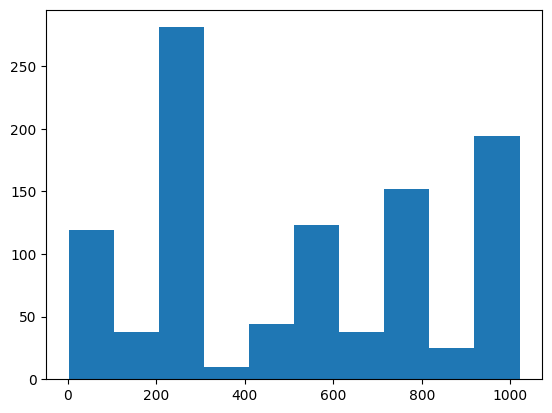

Total time for config: 7.390126466751099
Instance 8, T = 1.0, Proposal = MALA_MC, Acceptance = metropolis, Gap = 0.0000


C:\Users\vinit\AppData\Local\Temp\ipykernel_24416\596075925.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)


In [ ]:

from tqdm import tqdm
instances = pd.read_pickle('instances_new.pkl')
tot_instances = np.max(instances['Instance Number'].values)
print(tot_instances)
#tot_instances = 1
results = pd.DataFrame(columns = [
    'Instance Number',
    'Spins', 
    'Temperature', 
    'Connectivity',
    'Proposal',
    'Acceptance',
    'Gap',
    'Gap Lazy'
        ])
T_logmesh = np.logspace(-3, 3, 50)
T_round = np.sort( np.kron(np.array([1,5]), 10.**np.arange(-3,4)))
T_lim = np.array([0, np.inf]) 
T_arr = np.unique( np.concatenate((T_logmesh, T_round, T_lim))) 
#T_arr = np.delete(T_arr, -2) 
T_arr = [1]
delta_step = 0.2

for instance_num in range(800, tot_instances+1):
    cond  = (instances['Instance Number']==instance_num)
    n            = instances[cond]['Spins'].values[0]
    connectivity = instances[cond]['Connectivity'].values[0]
    J            = instances[cond]['J'].values[0]
    h            = instances[cond]['h'].values[0]

    print('Starting problem instance', instance_num, 'of', tot_instances, 'with n =', n)

    problem_inst = ProblemInstance(J, h)
    J_Q = problem_inst.J_quantum
    if np.linalg.norm(J_Q - J_Q.T) > 1e-8:
        print("Warning: J_Q is not symmetric, correcting...")
        problem_inst.J_quantum = (problem_inst.J_quantum + problem_inst.J_quantum.T)  # Ensure symmetry

    problem_inst.T = 1.0

    proposal_mats = {}

    T = 1.0
    prop_type = "MALA_MC"
    accept_type = 'metropolis'


    #transition_mat = adaptive_MALA_T_matrix(problem_inst, alpha=3.0, epsilon=0.2, num_samples=1000)
    transition_mat = adaptive_MALA_T_matrix_vec(problem_inst, alpha=3.0, epsilon=0.2, num_samples=1000)

    gap, _ = abs_spectral_gap(transition_mat)

    results_datum = {
        'Instance Number': instance_num,
        'Spins': n, 
        'Temperature': T, 
        'Connectivity': connectivity,
        'Proposal': prop_type,
        'Acceptance': accept_type,
        'Gap': gap,
        "delta_time_step_Trotter": delta_step
    }


    results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)

    print("Instance {}, T = {}, Proposal = {}, Acceptance = {}, Gap = {:.4f}".format(
        instance_num, T, prop_type, accept_type, gap))

    #results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)

    results_row = pd.DataFrame([results_datum])
    results_row.to_csv('results_MALA.csv', mode='a', header=not os.path.exists('results_MALA.csv'), index=False)



In [28]:
configs = all_configs(n)
idx_map = {tuple(c): i for i, c in enumerate(configs)}
idx_map

{(-1, -1, -1, -1, -1, -1, -1, -1, -1, -1): 0,
 (-1, -1, -1, -1, -1, -1, -1, -1, -1, 1): 1,
 (-1, -1, -1, -1, -1, -1, -1, -1, 1, -1): 2,
 (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1): 3,
 (-1, -1, -1, -1, -1, -1, -1, 1, -1, -1): 4,
 (-1, -1, -1, -1, -1, -1, -1, 1, -1, 1): 5,
 (-1, -1, -1, -1, -1, -1, -1, 1, 1, -1): 6,
 (-1, -1, -1, -1, -1, -1, -1, 1, 1, 1): 7,
 (-1, -1, -1, -1, -1, -1, 1, -1, -1, -1): 8,
 (-1, -1, -1, -1, -1, -1, 1, -1, -1, 1): 9,
 (-1, -1, -1, -1, -1, -1, 1, -1, 1, -1): 10,
 (-1, -1, -1, -1, -1, -1, 1, -1, 1, 1): 11,
 (-1, -1, -1, -1, -1, -1, 1, 1, -1, -1): 12,
 (-1, -1, -1, -1, -1, -1, 1, 1, -1, 1): 13,
 (-1, -1, -1, -1, -1, -1, 1, 1, 1, -1): 14,
 (-1, -1, -1, -1, -1, -1, 1, 1, 1, 1): 15,
 (-1, -1, -1, -1, -1, 1, -1, -1, -1, -1): 16,
 (-1, -1, -1, -1, -1, 1, -1, -1, -1, 1): 17,
 (-1, -1, -1, -1, -1, 1, -1, -1, 1, -1): 18,
 (-1, -1, -1, -1, -1, 1, -1, -1, 1, 1): 19,
 (-1, -1, -1, -1, -1, 1, -1, 1, -1, -1): 20,
 (-1, -1, -1, -1, -1, 1, -1, 1, -1, 1): 21,
 (-1, -1, -1, -1, -1,

In [31]:
spinconf2int(configs[0]), spins_to_index(configs[0:5])

(1023, array([1023, 1022, 1021, 1020, 1019], dtype=int64))

In [ ]:
class ProblemInst:
    n: int
    T: float                     # inverse temperature (as used in your code)
    J_quantum: np.ndarray        # shape (n, n), symmetric
    h_quantum: np.ndarray        # shape (n,)
    E_arr: np.ndarray            # length 2^n

# def build_problem(n: int, seed: int = 0) -> ProblemInst:
#     rng = np.random.default_rng(seed)
#     # Symmetric J with small entries:
#     A = rng.normal(0, 0.2, size=(n, n))
#     J = 0.5 * (A + A.T)
#     h = rng.normal(0, 0.2, size=n)

#     V = all_configs(n)  # (2^n, n) in {-1,+1}
#     # Classical Ising energy (sign convention chosen to be consistent)
#     # E(v) = - v^T J v - h^T v
#     E = np.einsum('bi,ij,bj->b', V, -J, V) - V @ h

#     return ProblemInst(n=n, T=1.0, J_quantum=J, h_quantum=h, E_arr=E.astype(float))


def assert_allclose(a, b, tol=1e-10, msg=""):
    if not np.allclose(a, b, atol=tol, rtol=0):
        raise AssertionError(msg or f"Arrays differ. Max abs diff: {np.max(np.abs(a-b))}")

def test_grad_agrees():
    prob = problem_inst #build_problem(n, seed=1)
    n = prob.n
    x = np.linspace(-1.0, 1.0, n)
    
    alpha = 3.0
    g1 = grad_U_mala(x, prob.J_quantum, prob.h_quantum, alpha)
    g2 = grad_U_mala_batch(x[None, :], prob.J_quantum, prob.h_quantum, alpha)[0]
    assert_allclose(g1, g2, 1e-12, "grad_U_mala vs grad_U_mala_batch disagree (B=1)")

    # Also check a real batch
    X = np.vstack([x, -x, 0.3 * x])
    G = grad_U_mala_batch(X, prob.J_quantum, prob.h_quantum, alpha)
    # spot check row 0 equals g1
    assert_allclose(G[0], g1, 1e-12, "Batch gradient first row mismatch")
    print("Batch gradient test passed.")

def test_logpdf_agrees():
    n = 4
    rng = np.random.default_rng(2)
    y = rng.normal(size=n)
    mean = rng.normal(size=n)
    # SPD cov and its cholesky P
    A = rng.normal(size=(n, n))
    cov = A @ A.T + 0.1 * np.eye(n)
    P = np.linalg.cholesky(cov)
    eps = 0.7

    lp1 = normal_dist_logpdf(y, mean, P, eps)
    lp2 = normal_dist_logpdf_batch(y[None, :], mean[None, :], P, eps)[0]
    assert_allclose(lp1, lp2, 1e-12, "normal_dist_logpdf vs batch disagree (B=1)")

    # multi-B should equal element-wise
    Y = np.vstack([y, y + 0.2, y - 0.1])
    M = np.vstack([mean, mean + 0.1, mean - 0.2])
    lpB = normal_dist_logpdf_batch(Y, M, P, eps)
    for i in range(3):
        lpi = normal_dist_logpdf(Y[i], M[i], P, eps)
        assert_allclose(lpB[i], lpi, 1e-12, f"logpdf row {i} mismatch")
    print("Batch logpdf test passed.")

def test_spin_index_mapping():
    for n in range(1, 6):
        V = all_configs(n)
        idx_batch = spins_to_index(V)
        idx_scalar = np.array([spinconf2int(v) for v in V])
        if not np.array_equal(idx_batch, idx_scalar):
            raise AssertionError(f"spins_to_index disagrees with spinconf2int for n={n}")
    print("Spin to index mapping test passed.") 

class RNGPatch:
    """Context manager to patch np.random.multivariate_normal to use randn, so
    both single-step and batched-step draw from the SAME primitive RNG calls.
    This allows exact equality tests for B=1 when seeding identically.
    """
    def __enter__(self):
        self._orig_mvn = np.random.multivariate_normal
        def mvn(mean=None, cov=None, size=None, check_valid=None, tol=None):
            mean = np.asarray(mean)
            n = mean.size
            if size is None:
                z = np.random.randn(n)
                P = np.linalg.cholesky(cov)  # cov is eps^2 P P^T in the call sites
                return mean + z @ P.T
            else:
                if size != 1:
                    raise NotImplementedError("This test patch only supports size=1 for the single-step function.")
                z = np.random.randn(n)
                P = np.linalg.cholesky(cov)
                return np.array([mean + z @ P.T])
        np.random.multivariate_normal = mvn
        return self
    def __exit__(self, exc_type, exc, tb):
        np.random.multivariate_normal = self._orig_mvn

def test_mala_step_equivalence_B1():
    prob = problem_inst #build_problem(n, seed=3)
    n = prob.n
    alpha = 3.0
    eps = 0.3

    rng = np.random.default_rng(123)
    x0 = rng.normal(size=n)
    cov = np.eye(n)
    cov_jit = cov + 1e-5 * np.eye(n)  # to mirror single-step jitter inside adaptive_MALA_step_new
    P = np.linalg.cholesky(cov)

    seeds = [7, 11, 19, 23, 29]
    with RNGPatch():
        for s in seeds:
            np.random.seed(s)
            x1, v1 = adaptive_MALA_step_new(x0.copy(), P, cov.copy(), eps, prob, alpha=alpha)

            np.random.seed(s)
            X2, V2 = adaptive_MALA_step_new_batch(x0[None, :].copy(), P, cov_jit.copy(), eps, prob, alpha=alpha)
            x2, v2 = X2[0], V2[0]

            if not np.allclose(x1, x2, atol=1e-12, rtol=0):
                raise AssertionError(f"MALA step x mismatch for seed {s} (max diff {np.max(np.abs(x1-x2))})")
            if not np.array_equal(v1, v2):
                raise AssertionError(f"MALA step v mismatch for seed {s}")
    print("Batched MALA step matches single-step for B=1.")

def run_all():
    test_grad_agrees()
    test_logpdf_agrees()
    test_spin_index_mapping()
    test_mala_step_equivalence_B1()
    print("✅ All tests passed!")

run_all()

Batch gradient test passed.
Batch logpdf test passed.
Spin to index mapping test passed.
Batched MALA step matches single-step for B=1.
✅ All tests passed!
